# AirBnB Optimal Price - EDA Notebook

## First Steps - Imports & Reading In Data

In [1]:
# Importing Libraries
import pandas as pd
pd.options.display.max_colwidth = 750   # Need it so I can better view amenities column
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import numpy as np
import pylab
import scipy.stats as stats
import pandarallel
from sklearn.preprocessing import StandardScaler, Normalizer, Binarizer, OrdinalEncoder, LabelEncoder
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import keras
import tensorflow as tf
import re

In [2]:
# Assigning filepaths of our airbnb data from Kaggle to variables
filename = "./train.csv"
filename2 = "./test.csv"

In [3]:
# Reading our CSV files into Pandas DataFrames
train = pd.read_csv(filename)
test = pd.read_csv(filename2)

## Combining Datasets

In [4]:
# Concatenating the two datasets into one. It's unnecessary to have pre-split training and test data. This is only useful for the holdout method.
# With cross validation and Keras' validation_split method, this pre-splitting of data is totally unnecessary. Besides, I want an overview of ALL
# of the data at once.
df = pd.concat([train, test])

In [5]:
# Sanity Check for confirming the concatenation worked out
train_num = train.shape[0]
print("Number of Observations for Pre-Split Training DataFrame: ", train_num)
print(" ")
test_num = test.shape[0]
print("Number of Observations for Pre-Split Testing DataFrame: ", test_num)
print(" ")
complete_num = train_num + test_num
print("Number of Observations for Concatenated DataFrame: ", complete_num)
print(" ")
if df.shape[0] == complete_num:
    print("Sanity Check -  Succesful!")
else:
    ("Sanity Check - Unsuccessful!")

Number of Observations for Pre-Split Training DataFrame:  74111
 
Number of Observations for Pre-Split Testing DataFrame:  25458
 
Number of Observations for Concatenated DataFrame:  99569
 
Sanity Check -  Succesful!


## Initial EDA & Data Clean-Up

In [6]:
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Essentials,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c034-459c-bc82-6522c957627c.jpg?aki_policy=small,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Washer,Dryer,""Smoke detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4b65-452a-b48a-bfecb3b58a66.jpg?aki_policy=small,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air conditioning"",Kitchen,Breakfast,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_50""}",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9e3a-4fa9-aa54-bbd5ea26538d.jpg?aki_policy=small,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Kitchen,""Indoor fireplace"",""Buzzer/wireless intercom"",Heating,Washer,Dryer,""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Fire extinguisher"",Essentials}",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9c86-41ea-a735-43d933111063.jpg?aki_policy=small,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditioning"",Kitchen,""Elevator in building"",Heating,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo}",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [7]:
df.nunique()
# Every observation has its own unique ID, so I'll both set and sort the DataFrame by the 'id' column.

id                        99569
log_price                   767
property_type                35
room_type                     3
amenities                 88651
accommodates                 16
bathrooms                    18
bed_type                      5
cancellation_policy           6
cleaning_fee                  2
city                          6
description               98683
first_review               2643
host_has_profile_pic          2
host_identity_verified        2
host_response_rate           80
host_since                 3118
instant_bookable              2
last_review                1457
latitude                  99569
longitude                 99569
name                      98653
neighbourhood               627
number_of_reviews           394
review_scores_rating         56
thumbnail_url             88468
zipcode                     801
bedrooms                     12
beds                         19
dtype: int64

In [8]:
# Confirming the datatypes in our DataFrame
df.dtypes
# We have some booleans here. They don't go well with ML models. Going to need to convert them to binary.

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

In [9]:
# Sorting DF by zipcode
df.sort_values(by=['zipcode'], inplace=True)

In [10]:
# # Sorting DataFrame by our index before setting it as such
# df.sort_values(by=["host_since"], inplace=True, ascending=True)   # host_since is the closest thing to a date or date_time column we have
# df.set_index("host_since", inplace=True)

In [11]:
# Dealing with null values
df.isnull().sum().sum()
# We're going to drop a lot of rows. Luckily, we have enough.
# If we kept these, converting the NaNs to zeroes would have given us an imbalanced dataset.
# Not worth dealing with that.

138076

In [12]:
# Removing null values. Can't interpolate them considering we lack a timeseries variable. Not every sample is worth keeping.
df.dropna(axis=0, inplace=True)

In [13]:
# Converting bools to binary ints
df.loc[(df["cleaning_fee"] == False), 'cleaning_fee'] = 0
df.loc[(df["cleaning_fee"] == True), 'cleaning_fee'] = 1

df.loc[(df["instant_bookable"] == 'f'), 'instant_bookable'] = 0
df.loc[(df["instant_bookable"] == 't'), 'instant_bookable'] = 1

df.loc[(df["host_identity_verified"] == 'f'), 'host_identity_verified'] = 0
df.loc[(df["host_identity_verified"] == 't'), 'host_identity_verified'] = 1

## Feature Engineering and Exploring our Target

In [14]:
# Inverting 'price_log' to get original price values WIP
df["price"] = np.exp(df["log_price"])

# rounded the decimal places to the second place
df["price"] = round(df.price, 2)

In [15]:
# Confirming the average prices WIP
price_mean = df["price"].mean()
price_sorted = df["price"].sort_values()

print("Average AirBnB Price Listings: ", price_mean)
print(" ")
print("Sorted AirbnB Price Listings: ", price_sorted)

Average AirBnB Price Listings:  146.1157082748948
 
Sorted AirbnB Price Listings:  11632       1.0
3898        5.0
6515       10.0
28693      10.0
66762      10.0
          ...  
49711    1950.0
37424    1950.0
39465    1950.0
61826    1995.0
55453    1999.0
Name: price, Length: 38502, dtype: float64


In [16]:
df.price.describe

<bound method NDFrame.describe of 54511    259.0
20313     89.0
68172    225.0
62506    185.0
56709    199.0
         ...  
27979    149.0
10418    250.0
33983    197.0
43630    148.0
8264     105.0
Name: price, Length: 38502, dtype: float64>

In [17]:
# Confirming the absolute value of the correlations of our features with our target, 'price'.
# Its interesting that the logarithm of 'price' is only 85% correlated
abs(df.corr()["price"]).sort_values(ascending=False)

price                   1.000000
log_price               0.855574
accommodates            0.583134
bedrooms                0.550352
beds                    0.488349
bathrooms               0.459425
longitude               0.060459
review_scores_rating    0.054083
number_of_reviews       0.052034
latitude                0.012907
id                      0.005358
Name: price, dtype: float64

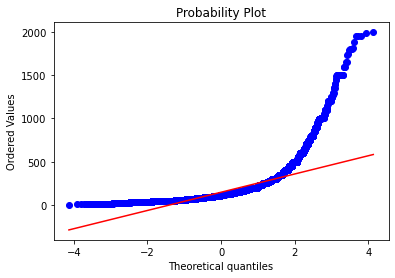

In [18]:
# Probability plot for price
stats.probplot(df['price'], dist="norm", plot=pylab)
pylab.show()
# Looks like price listings are probably around $100 - $300 per night. The probabilities of price skewing towards nothing or $2000 are very unlikely

## Feature Engineering: Number of Amenities

In [19]:
df["amenities"].iloc[10]

'{"Wireless Internet","Air conditioning","Pets allowed",Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Private entrance"}'

In [20]:
####### WIP ########

# def clean_data(text):
#     """
#     Accepts a single text document and performs several regex substitutions in order to clean the document. 
    
#     Parameters
#     ----------
#     text: string or object 
    
#     Returns
#     -------
#     text: string or object
#     """
    
#     # order of operations - apply the expression from top to bottom
#     messy = '/[^, a-zA-Z0-9-]+/g'
    
#     text = re.sub(messy, "", text)
    
#     # apply case normalization 
#     return text

In [21]:
# Going to clean up all punctuation save for commas with regex function. Before converting to the number of/len() of all tokens within that row.
# Going to do this with a function and apply it with pandarallel

#### WIP ####
# df["amenities"] = df["amenities"].apply(clean_data)
# df['amenities'] = len(df.amenities)

In [22]:
# df["amenities"]

# Dropping high cardinality and otherwise useless columns
---
- Will need to drop 'log_price' to avoid target/data leakage

In [23]:
# Assigning high cardinal columns to a variable
cutoff = 100
HCC_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]

In [24]:
# Confirming what the HCC columns are
HCC_cols

['amenities',
 'description',
 'first_review',
 'host_since',
 'last_review',
 'name',
 'neighbourhood',
 'thumbnail_url',
 'zipcode']

In [25]:
# Creating a dataframe out of these HCC columns (excluding those that I know are important)
# If there is enough time for a stretch goal, I'll remove description from this list and vectorize it for sentiment analysis and include it in our
# deployed web app
df_HCC = df[[
             'description',
             'first_review',
             'last_review',
             'name',
             'thumbnail_url'
            ]]

In [26]:
df_HCC.head(3)

,description,first_review,last_review,name,thumbnail_url
54511,"At this Sonder, you'll love the exposed brick, modern kitchen, and expansive storage space. This apartment is located in Downtown Crossing, known for quality shopping, and close to Park T station. Every booking is instantly confirmed. Every call or message is answered within minutes. Every home is equipped with crisp linens, high-speed Wi-Fi, and kitchen and bath essentials—everything you need for an exceptional stay. Our concierge is available by phone, email, or Messenger 24/7. Don’t hesitate to contact us if you need anything, from extra towels to restaurant recommendations. Otherwise, we’ll leave you to enjoy your stay. Downtown Crossing has plenty to offer within walking distance. Try out VERTS Mediterranean Grill or Central Bistro...",2017-08-13,2017-09-27,Stunning 4BR in Downtown Crossing,https://a0.muscache.com/im/pictures/ac7e1866-775e-4b13-acd4-ce1b0ea6a480.jpg?aki_policy=small
20313,"We are a family-operated Airbnb. This cute and cool one BR duplex is in an amazing location in the heart of Little Italy and is close to many tourist attractions, cozy cafes and shops. Cute and cool one bedroom duplex apartment on the 2nd floor, located in the North End's most lively stretch. Bedroom with a queen size bed and bathroom with a tub and shower are on the upper floor; kitchen and living room on the lower floor with a sofa bed that can sleep one adult or two small children. Steep stairs from lower floor to bedroom. May not be appropriate for guests who have difficulty with stairs or for very young children. Amenities include cable, internet Wi Fi, DVD, A/C on both floors, full kitchenette, linens and towels. Guests can ...",2014-05-16,2017-10-02,Boston Best One Bdrm duplex (h2c),https://a0.muscache.com/im/pictures/d4b6952f-d9b2-45ef-8376-cfb88546452e.jpg?aki_policy=small
68172,Situated on the best street on Beacon Hill this ho,2017-09-18,2017-10-04,Beacon Hill PERFECT one bedroom!!!!,https://a0.muscache.com/im/pictures/a6117c4e-90c5-42fe-8b45-ca2d63e5b384.jpg?aki_policy=small


In [27]:
df.shape

(38502, 30)

In [28]:
df.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'price'],
      dtype='object')

In [29]:
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,price
54511,17618928,5.556828,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air conditioning"",Kitchen,Elevator,Heating,""Family/kid friendly"",Washer,Dryer,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""Hot water"",""Bed linens"",Microwave,""Coffee maker"",Refrigerator,Dishwasher,""Dishes and silverware"",""Cooking basics"",Oven,Stove,""Long term stays allowed""}",8,2.0,Real Bed,strict,1,...,-71.060408,Stunning 4BR in Downtown Crossing,Downtown Crossing,2,100.0,https://a0.muscache.com/im/pictures/ac7e1866-775e-4b13-acd4-ce1b0ea6a480.jpg?aki_policy=small,02108,4.0,4.0,259.0
20313,14884022,4.488636,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""Air conditioning"",Kitchen,""Pets allowed"",""Buzzer/wireless intercom"",Heating,""Smoke detector"",""Carbon monoxide detector"",Essentials,Shampoo,""24-hour check-in"",Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""translation missing: en.hosting_amenity_50"",""Self Check-In"",Lockbox,""Bed linens""}",4,1.0,Real Bed,strict,1,...,-71.052334,Boston Best One Bdrm duplex (h2c),North End,94,89.0,https://a0.muscache.com/im/pictures/d4b6952f-d9b2-45ef-8376-cfb88546452e.jpg?aki_policy=small,02108,1.0,2.0,89.0
68172,18111425,5.416100,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kitchen,""Pets allowed"",Heating,Washer,Dryer,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace""}",2,1.0,Real Bed,flexible,1,...,-71.065911,Beacon Hill PERFECT one bedroom!!!!,Beacon Hill,3,87.0,https://a0.muscache.com/im/pictures/a6117c4e-90c5-42fe-8b45-ca2d63e5b384.jpg?aki_policy=small,02108,1.0,1.0,225.0
62506,13530190,5.220356,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Washer,Dryer,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,""24-hour check-in"",Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""Self Check-In"",Keypad}",3,1.5,Real Bed,strict,1,...,-71.055673,"Coolest tri level, BEST location by Faneuil Hall",Downtown,33,87.0,https://a0.muscache.com/im/pictures/91091236/a24ee881_original.jpg?aki_policy=small,02108,1.0,1.0,185.0
56709,2326775,5.293305,Apartment,Entire home/apt,"{Internet,""Wireless Internet"",Kitchen,Heating,""Family/kid friendly"",""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",""Laptop friendly workspace"",""translation missing: en.hosting_amenity_50""}",2,1.0,Real Bed,moderate,0,...,-71.069026,Prime Location Beacon Hill 1 BR,Beacon Hill,35,91.0,https://a0.muscache.com/im/pictures/68883907-c355-4701-b3ef-544f8e7b882b.jpg?aki_policy=small,02108,1.0,1.0,199.0


In [30]:
df['zipcode'].sort_values()

54511                                                   02108
25530                                                   02108
9677                                                    02108
2894                                                    02108
64803                                                   02108
                                 ...                         
35195                                                   94158
63010                                                   94158
42509                                                   94158
67215                                                   94158
8264     95202\r\r\r\r\r\r\n\r\r\r\r\r\r\n\r\r\r\r\r\r\n94158
Name: zipcode, Length: 38502, dtype: object

In [31]:
df['zipcode'].unique()

array(['02108', '02109', '02110', '02111', '02113', '02114', '02115',
       '02116', '02118', '02119', '02120', '02121', '02122', '02124',
       '02125', '02126', '02127', '02128', '02129', '02130', '02131',
       '02132', '02134', '02135', '02136', '02139', '02143', '02145',
       '02186', '02199', '02210', '02215', '02467', '10001', '10001.0',
       '10002', '10002.0', '10003', '10003-8623', '10003.0', '10004',
       '10005', '10006', '10007', '10007.0', '10009', '10009.0', '10010',
       '10010.0', '10011', '10011.0', '10012', '10012.0', '10013',
       '10013.0', '10014', '10014.0', '10016', '10017', '10018',
       '10018.0', '10019', '10019.0', '10021', '10022', '10023', '10024',
       '10025', '10026', '10026.0', '10027', '10027.0', '10028', '10029',
       '10029.0', '10030', '10030.0', '10031', '10032', '10033', '10034',
       '10035', '10035.0', '10036', '10036.0', '10037', '10037.0',
       '10038', '10038.0', '10039', '10040', '10044', '10048', '10065',
       '100

In [32]:
len(df['zipcode'].unique())

653

In [33]:
def clean_data(zipcode):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    Parameters
    ----------
    text: string or object 
    Returns
    -------
    text: string or object
    """
    # order of operations - apply the expression from top to bottom
    non_alpha = '[^, a-zA-Z0-9]'
    replace_with = " "

    re_zips = re.sub(non_alpha, replace_with, zipcode)
    split_zips = re_zips.split(" ", 1)[0]

    return split_zips

In [34]:
oddValue = df[df['zipcode'] == '1m'].index
df.drop(oddValue, inplace=True)

badValue = df[df['zipcode'] == '95202\r\r\r\r\r\r\n\r\r\r\r\r\r\n\r\r\r\r\r\r\n94158'].index
df.drop(badValue, inplace=True)

weirdValue = df[df['zipcode'] == '11249\r\r\r\r\r\r\n11249'].index
df.drop(weirdValue, inplace=True)

In [35]:
df['zipcode'] = df['zipcode'].apply(clean_data)

In [37]:
df['zipcode'].unique()

array(['02108', '02109', '02110', '02111', '02113', '02114', '02115',
       '02116', '02118', '02119', '02120', '02121', '02122', '02124',
       '02125', '02126', '02127', '02128', '02129', '02130', '02131',
       '02132', '02134', '02135', '02136', '02139', '02143', '02145',
       '02186', '02199', '02210', '02215', '02467', '10001', '10002',
       '10003', '10004', '10005', '10006', '10007', '10009', '10010',
       '10011', '10012', '10013', '10014', '10016', '10017', '10018',
       '10019', '10021', '10022', '10023', '10024', '10025', '10026',
       '10027', '10028', '10029', '10030', '10031', '10032', '10033',
       '10034', '10035', '10036', '10037', '10038', '10039', '10040',
       '10044', '10048', '10065', '10069', '10075', '10118', '10119',
       '10128', '10129', '10162', '10270', '10279', '10280', '10282',
       '10301', '10302', '10303', '10304', '10305', '10306', '10307',
       '10308', '10309', '10310', '10312', '10314', '10451', '10452',
       '10453', '104

In [38]:
# Converting zipcode to int
df['zipcode'] = df['zipcode'].astype(int)

In [39]:
df['zipcode'].sort_values()

54511     2108
25530     2108
9677      2108
2894      2108
64803     2108
         ...  
63010    94158
42509    94158
33983    94158
67215    94158
43630    94158
Name: zipcode, Length: 38499, dtype: int64

In [40]:
df['zipcode'].unique()

array([ 2108,  2109,  2110,  2111,  2113,  2114,  2115,  2116,  2118,
        2119,  2120,  2121,  2122,  2124,  2125,  2126,  2127,  2128,
        2129,  2130,  2131,  2132,  2134,  2135,  2136,  2139,  2143,
        2145,  2186,  2199,  2210,  2215,  2467, 10001, 10002, 10003,
       10004, 10005, 10006, 10007, 10009, 10010, 10011, 10012, 10013,
       10014, 10016, 10017, 10018, 10019, 10021, 10022, 10023, 10024,
       10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033,
       10034, 10035, 10036, 10037, 10038, 10039, 10040, 10044, 10048,
       10065, 10069, 10075, 10118, 10119, 10128, 10129, 10162, 10270,
       10279, 10280, 10282, 10301, 10302, 10303, 10304, 10305, 10306,
       10307, 10308, 10309, 10310, 10312, 10314, 10451, 10452, 10453,
       10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462,
       10463, 10464, 10465, 10466, 10467, 10468, 10469, 10470, 10471,
       10472, 10473, 10474, 10475, 10550, 11101, 11102, 11103, 11104,
       11105, 11106,

In [41]:
len(df['zipcode'].unique())

559

In [42]:
# # cleaning 'zip_code'

# df['zipcode'] = df['zipcode'].str.split('.').str[0]
# df['zipcode'] = df['zipcode'].str.split('-').str[0]

# oddValue = df[df['zipcode'] == '1m'].index
# df.drop(oddValue, inplace=True)

# badValue = df[df['zipcode'] == '95202\r\r\r\r\r\r\n\r\r\r\r\r\r\n\r\r\r\r\r\r\n94158'].index
# df.drop(badValue, inplace=True)

# weirdValue = df[df['zipcode'] == '11249\r\r\r\r\r\r\n11249'].index
# df.drop(weirdValue, inplace=True)

In [43]:
df.drop(columns="host_has_profile_pic", inplace=True)  # Why would a profile pic matter? lol
df.drop(columns="host_response_rate", inplace=True)   # Not important. We just need the host to respond is all. The rate at which they do is superfluous
df.drop(columns="number_of_reviews", inplace=True)   # Its not the number of reviews that matter, but the average rating of them
df.drop(columns="log_price", inplace=True)   # This will lead to data leakage
df.drop(columns="description", inplace=True)   # Literally just a written version of our lat, long, and zipcode features
df.drop(columns="first_review", inplace=True)  # Unnecessary
df.drop(columns="last_review", inplace=True)  # Useless
df.drop(columns="thumbnail_url", inplace=True)  # When do URLs ever help ML models?
df.drop(columns="id", inplace=True)   # Since we are IDs necessary? 
df.drop(columns="amenities", inplace=True) # This column is a messed up dictionary. Will be dropping it for now. Will add it back in later when perfecting the model

In [44]:
df.head(3)

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,host_since,instant_bookable,latitude,longitude,name,neighbourhood,review_scores_rating,zipcode,bedrooms,beds,price
54511,Apartment,Entire home/apt,8,2.0,Real Bed,strict,1,Boston,1,2014-02-14,1,42.356821,-71.060408,Stunning 4BR in Downtown Crossing,Downtown Crossing,100.0,2108,4.0,4.0,259.0
20313,Apartment,Entire home/apt,4,1.0,Real Bed,strict,1,Boston,0,2013-03-22,1,42.364847,-71.052334,Boston Best One Bdrm duplex (h2c),North End,89.0,2108,1.0,2.0,89.0
68172,Apartment,Entire home/apt,2,1.0,Real Bed,flexible,1,Boston,0,2014-10-04,1,42.357428,-71.065911,Beacon Hill PERFECT one bedroom!!!!,Beacon Hill,87.0,2108,1.0,1.0,225.0


## Plotly Express - Scatter Mapbox

In [45]:
# figure = px.scatter_mapbox(
#                            df,
#                            lat='latitude',
#                            lon='longitude',
#                            hover_name='name',
#                            hover_data=['price',
#                                        'review_scores_rating'],
#                            color_discrete_sequence=["goldenrod"],
#                            zoom=3, height=350
#                            )

# figure.update_layout(mapbox_style="open-street-map")

# figure.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# figure.show()

# Plotly Express - Analysis: 
---

We only have data on Los Angeles, San Francisco, Chicago, D.C., NYC & Boston. The Continental USA. Considering that I reversed the natural logarithm of our 'log_price' variable, it seems that those price values are all in USD.

Given this, I believe training my model on just these cities alone (with ample regularization tuning) will be enough to account for other major cities around the US.

In [46]:
# # Doing this here after the big Plotly Dash map
df.drop(columns="name", inplace=True)                      # Names are purely nominal
df.drop(columns="latitude", inplace=True)                 # Won't work with web app
df.drop(columns="longitude", inplace=True)
df.drop(columns="neighbourhood", inplace=True)          # Redudant when we already have zipcode

## Automated EDA 

In [47]:
# Report = ProfileReport(df, explorative=True).to_notebook_iframe()
# Report

Given Spearman's p, the features most correlated with price are accommodates, beds, bedrooms, and bathrooms (in that order). Review_scores_rating barely correlates at all. Which is rather surprising.  

## FINAL SELECTION OF FEATURES
---
- save for 'price' as it is our target

In [48]:
df.columns

Index(['property_type', 'room_type', 'accommodates', 'bathrooms', 'bed_type',
       'cancellation_policy', 'cleaning_fee', 'city', 'host_identity_verified',
       'host_since', 'instant_bookable', 'review_scores_rating', 'zipcode',
       'bedrooms', 'beds', 'price'],
      dtype='object')

In [49]:
df

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,host_since,instant_bookable,review_scores_rating,zipcode,bedrooms,beds,price
54511,Apartment,Entire home/apt,8,2.0,Real Bed,strict,1,Boston,1,2014-02-14,1,100.0,2108,4.0,4.0,259.0
20313,Apartment,Entire home/apt,4,1.0,Real Bed,strict,1,Boston,0,2013-03-22,1,89.0,2108,1.0,2.0,89.0
68172,Apartment,Entire home/apt,2,1.0,Real Bed,flexible,1,Boston,0,2014-10-04,1,87.0,2108,1.0,1.0,225.0
62506,Apartment,Entire home/apt,3,1.5,Real Bed,strict,1,Boston,1,2012-08-02,1,87.0,2108,1.0,1.0,185.0
56709,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,0,Boston,1,2014-07-28,0,91.0,2108,1.0,1.0,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10358,Apartment,Private room,2,1.0,Real Bed,strict,1,SF,1,2015-03-29,0,96.0,94158,1.0,1.0,179.0
27979,Apartment,Private room,3,1.0,Real Bed,strict,1,SF,1,2013-04-30,0,98.0,94158,1.0,1.0,149.0
10418,Apartment,Entire home/apt,2,1.0,Real Bed,strict,1,SF,0,2017-01-27,1,97.0,94158,0.0,1.0,250.0
33983,Apartment,Private room,1,1.0,Real Bed,strict,0,SF,1,2015-03-29,1,97.0,94158,1.0,1.0,197.0


## Data Preprocessing

Creating both standardized and normalized versions of this dataset for our predictive model. Which preprocessing technique is best for our model? We'll just have to experiment with both!

- Will need to vectorize whichever string/object columns I end up using after dropping HCC and other useless columns up above

In [50]:
# Not going to use ordinal, OHE, or dummy encoding. It creates far too many features. We'll run into the curse of dimensionality if I do this.
# Gonna need to embed our categorical columns. Might just use difference encoding for the converted binary columns though.
# df_dummy = pd.get_dummies(df)
# df_dummy

In [51]:
df_encoded = df.copy()

In [52]:
df_encoded.head()

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,host_since,instant_bookable,review_scores_rating,zipcode,bedrooms,beds,price
54511,Apartment,Entire home/apt,8,2.0,Real Bed,strict,1,Boston,1,2014-02-14,1,100.0,2108,4.0,4.0,259.0
20313,Apartment,Entire home/apt,4,1.0,Real Bed,strict,1,Boston,0,2013-03-22,1,89.0,2108,1.0,2.0,89.0
68172,Apartment,Entire home/apt,2,1.0,Real Bed,flexible,1,Boston,0,2014-10-04,1,87.0,2108,1.0,1.0,225.0
62506,Apartment,Entire home/apt,3,1.5,Real Bed,strict,1,Boston,1,2012-08-02,1,87.0,2108,1.0,1.0,185.0
56709,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,0,Boston,1,2014-07-28,0,91.0,2108,1.0,1.0,199.0


In [53]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print (x,)

In [54]:
# unique(df.city)

In [55]:
# unique(df.property_type)

In [56]:
# unique(df.bed_type)

In [57]:
# unique(df.room_type)

In [58]:
# unique(df.cancellation_policy)

In [59]:
df

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,host_since,instant_bookable,review_scores_rating,zipcode,bedrooms,beds,price
54511,Apartment,Entire home/apt,8,2.0,Real Bed,strict,1,Boston,1,2014-02-14,1,100.0,2108,4.0,4.0,259.0
20313,Apartment,Entire home/apt,4,1.0,Real Bed,strict,1,Boston,0,2013-03-22,1,89.0,2108,1.0,2.0,89.0
68172,Apartment,Entire home/apt,2,1.0,Real Bed,flexible,1,Boston,0,2014-10-04,1,87.0,2108,1.0,1.0,225.0
62506,Apartment,Entire home/apt,3,1.5,Real Bed,strict,1,Boston,1,2012-08-02,1,87.0,2108,1.0,1.0,185.0
56709,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,0,Boston,1,2014-07-28,0,91.0,2108,1.0,1.0,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10358,Apartment,Private room,2,1.0,Real Bed,strict,1,SF,1,2015-03-29,0,96.0,94158,1.0,1.0,179.0
27979,Apartment,Private room,3,1.0,Real Bed,strict,1,SF,1,2013-04-30,0,98.0,94158,1.0,1.0,149.0
10418,Apartment,Entire home/apt,2,1.0,Real Bed,strict,1,SF,0,2017-01-27,1,97.0,94158,0.0,1.0,250.0
33983,Apartment,Private room,1,1.0,Real Bed,strict,0,SF,1,2015-03-29,1,97.0,94158,1.0,1.0,197.0


In [60]:
unique(df.zipcode)

2108
2109
2110
2111
2113
2114
2115
2116
2118
2119
2120
2121
2122
2124
2125
2126
2127
2128
2129
2130
2131
2132
2134
2135
2136
2139
2143
2145
2186
2199
2210
2215
2467
10001
10002
10003
10004
10005
10006
10007
10009
10010
10011
10012
10013
10014
10016
10017
10018
10019
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10044
10048
10065
10069
10075
10118
10119
10128
10129
10162
10270
10279
10280
10282
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10312
10314
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10550
11101
11102
11103
11104
11105
11106
11109
11201
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11249
11354
11355
11356
11357
11358
11360
1

In [61]:
# List comprehension version that returns numpy arrays 
# label_encoder = LabelEncoder()

# objects = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city', 'name', 'neighbourhood']

# [label_encoder.fit_transform(df[obj]).astype(int) for obj in objects]

In [62]:
# Want to refactor code to grab all object dtypes and place them in this empty list
# dtype_obj = []

# for obj in df.dtypes:
#     return dtype_obj.append()

In [63]:
# USING LABEL ENCODING IN A FOR LOOP! THIS IS SO MUCH EASIER!! WE KEEP THE SAME NUMBER OF FEATURES! 
# OHE is better used to binarize categories within a feature, turning them into their own individual features
# Attempting this for loop with a OrdinalEncoder doesn't work. 
# Got this error back - ValueError: Expected 2D array, got 1D array instead:
#                       array=['Condominium' 'Other' 'Apartment' ... 'Apartment' 'Condominium' 'Guesthouse']. Reshape your data either using
# array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample
label_encoder = LabelEncoder()

objects = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']

for obj in objects:
    df_encoded[obj] = label_encoder.fit_transform(df_encoded[obj]).astype(int)

In [64]:
df_encoded

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,host_since,instant_bookable,review_scores_rating,zipcode,bedrooms,beds,price
54511,0,0,8,2.0,4,2,1,0,1,2014-02-14,1,100.0,2108,4.0,4.0,259.0
20313,0,0,4,1.0,4,2,1,0,0,2013-03-22,1,89.0,2108,1.0,2.0,89.0
68172,0,0,2,1.0,4,0,1,0,0,2014-10-04,1,87.0,2108,1.0,1.0,225.0
62506,0,0,3,1.5,4,2,1,0,1,2012-08-02,1,87.0,2108,1.0,1.0,185.0
56709,0,0,2,1.0,4,1,0,0,1,2014-07-28,0,91.0,2108,1.0,1.0,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10358,0,1,2,1.0,4,2,1,5,1,2015-03-29,0,96.0,94158,1.0,1.0,179.0
27979,0,1,3,1.0,4,2,1,5,1,2013-04-30,0,98.0,94158,1.0,1.0,149.0
10418,0,0,2,1.0,4,2,1,5,0,2017-01-27,1,97.0,94158,0.0,1.0,250.0
33983,0,1,1,1.0,4,2,0,5,1,2015-03-29,1,97.0,94158,1.0,1.0,197.0


In [65]:
# Converting 'host_since' to datetime
# df_encoded['host_since'] = pd.to_datetime(df_encoded['host_since'])

In [66]:
# I want to refactor this into a conditional statement or for loop
df_encoded['cleaning_fee'] = df_encoded['cleaning_fee'].astype(int)
df_encoded['host_identity_verified'] = df_encoded['host_identity_verified'].astype(int)
df_encoded['instant_bookable'] = df_encoded['instant_bookable'].astype(int)
df_encoded['bathrooms'] = df_encoded['bathrooms'].astype(int)
df_encoded['review_scores_rating'] = df_encoded['review_scores_rating'].astype(int)
df_encoded['bedrooms'] = df_encoded['bedrooms'].astype(int)
df_encoded['beds'] = df_encoded['beds'].astype(int)


In [67]:
df_encoded.dtypes

property_type               int64
room_type                   int64
accommodates                int64
bathrooms                   int64
bed_type                    int64
cancellation_policy         int64
cleaning_fee                int64
city                        int64
host_identity_verified      int64
host_since                 object
instant_bookable            int64
review_scores_rating        int64
zipcode                     int64
bedrooms                    int64
beds                        int64
price                     float64
dtype: object

In [68]:
unique(df_encoded.zipcode)

2108
2109
2110
2111
2113
2114
2115
2116
2118
2119
2120
2121
2122
2124
2125
2126
2127
2128
2129
2130
2131
2132
2134
2135
2136
2139
2143
2145
2186
2199
2210
2215
2467
10001
10002
10003
10004
10005
10006
10007
10009
10010
10011
10012
10013
10014
10016
10017
10018
10019
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10044
10048
10065
10069
10075
10118
10119
10128
10129
10162
10270
10279
10280
10282
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10312
10314
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10550
11101
11102
11103
11104
11105
11106
11109
11201
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11249
11354
11355
11356
11357
11358
11360
1

In [69]:
from datetime import datetime, date, timezone
import calendar
datetime_obj = datetime.strptime("2021-06-22", "%Y-%m-%d")
# timestamp = calendar.timegm(datetime_obj.timetuple())
# dt = datetime.utcfromtimestamp(timestamp)
utc_timestamp_seconds = datetime_obj.replace(tzinfo=timezone.utc).timestamp()
utc_timestamp_days = int(utc_timestamp_seconds / 86400)

In [70]:
datetime_obj

datetime.datetime(2021, 6, 22, 0, 0)

In [71]:
utc_timestamp_days

18800

In [72]:
df_encoded.host_since

54511    2014-02-14
20313    2013-03-22
68172    2014-10-04
62506    2012-08-02
56709    2014-07-28
            ...    
10358    2015-03-29
27979    2013-04-30
10418    2017-01-27
33983    2015-03-29
43630    2012-06-11
Name: host_since, Length: 38499, dtype: object

In [73]:
df_encoded.dtypes

property_type               int64
room_type                   int64
accommodates                int64
bathrooms                   int64
bed_type                    int64
cancellation_policy         int64
cleaning_fee                int64
city                        int64
host_identity_verified      int64
host_since                 object
instant_bookable            int64
review_scores_rating        int64
zipcode                     int64
bedrooms                    int64
beds                        int64
price                     float64
dtype: object

In [74]:
# Converting datetime to UTC
from datetime import datetime, date, timezone
import calendar


def datetime_to_UTC_days(host_since):
    """"
    Converts datetime object of dates since becoming an AirBnB host to the number of days its been since then.
    """
    datetime_obj = datetime.strptime(host_since, "%Y-%m-%d")
    utc_timestamp_seconds = datetime_obj.replace(tzinfo=timezone.utc).timestamp()
    utc_timestamp_days = int(utc_timestamp_seconds / 86400)
    
    return utc_timestamp_days

In [75]:
unique(df_encoded.host_since)

2014-02-14
2013-03-22
2014-10-04
2012-08-02
2014-07-28
2012-10-01
2014-09-02
2014-08-26
2010-03-14
2015-02-21
2014-12-18
2014-08-12
2017-07-17
2013-12-27
2009-07-22
2011-11-08
2015-03-03
2013-09-18
2014-10-26
2016-06-22
2015-04-23
2015-11-08
2015-12-07
2013-11-14
2016-03-09
2016-09-27
2015-02-01
2012-05-12
2015-08-15
2015-03-17
2014-10-13
2016-08-23
2010-11-07
2016-11-10
2017-02-04
2016-05-11
2013-11-25
2016-05-30
2015-10-16
2015-01-20
2015-10-05
2015-02-22
2013-10-13
2016-06-15
2012-03-25
2016-11-04
2013-01-17
2016-09-29
2016-09-14
2016-03-04
2016-11-29
2014-11-19
2012-12-08
2014-10-14
2017-02-25
2015-03-30
2014-10-10
2014-01-13
2016-06-05
2015-04-16
2013-03-25
2015-10-02
2014-10-07
2016-09-12
2011-12-05
2016-08-17
2015-08-02
2015-07-26
2015-09-11
2014-06-10
2015-03-15
2011-10-11
2015-08-17
2013-10-14
2014-05-07
2011-11-26
2013-10-11
2014-10-08
2011-07-13
2012-06-25
2015-04-09
2015-01-07
2016-09-16
2017-05-28
2012-03-12
2012-09-21
2015-08-08
2015-05-03
2014-04-10
2017-01-07
2015-09-24

In [76]:
df_encoded['host_since'] = df_encoded['host_since'].apply(datetime_to_UTC_days)

In [77]:
unique(df_encoded.host_since)

16115
15786
16347
15554
16279
15614
16315
16308
14682
16487
16422
16294
17364
16066
14447
15286
16497
15966
16369
16974
16548
16747
16776
16023
16869
17071
16467
15472
16662
16511
16356
17036
14920
17115
17201
16932
16034
16951
16724
16455
16713
16488
15991
16967
15424
17109
15722
17073
17058
16864
17134
16393
15682
16357
17222
16524
16353
16083
16957
16541
15789
16710
16350
17056
15313
17030
16649
16642
16689
16231
16509
15258
16664
15992
16197
15304
15989
16351
15168
15516
16534
16442
17060
17314
15411
15604
16655
16558
16170
17173
16702
15371
16046
15223
16272
16901
16610
16301
16258
16796
16247
15561
16708
15794
15248
16423
16899
15857
17021
16682
16111
16897
14503
16469
16518
15696
16071
16410
15378
17184
16078
16323
16670
15709
16284
16452
16098
15136
17062
15401
17342
16607
16407
16316
16772
15644
16297
15927
16671
15983
16787
16842
16310
16352
16734
16491
15617
15740
16178
17344
16260
17047
16566
16093
16711
16688
16392
17333
16239
15736
17105
15715
16453
16084
16275
17132
1660

In [78]:
df_encoded

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,host_since,instant_bookable,review_scores_rating,zipcode,bedrooms,beds,price
54511,0,0,8,2,4,2,1,0,1,16115,1,100,2108,4,4,259.0
20313,0,0,4,1,4,2,1,0,0,15786,1,89,2108,1,2,89.0
68172,0,0,2,1,4,0,1,0,0,16347,1,87,2108,1,1,225.0
62506,0,0,3,1,4,2,1,0,1,15554,1,87,2108,1,1,185.0
56709,0,0,2,1,4,1,0,0,1,16279,0,91,2108,1,1,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10358,0,1,2,1,4,2,1,5,1,16523,0,96,94158,1,1,179.0
27979,0,1,3,1,4,2,1,5,1,15825,0,98,94158,1,1,149.0
10418,0,0,2,1,4,2,1,5,0,17193,1,97,94158,0,1,250.0
33983,0,1,1,1,4,2,0,5,1,16523,1,97,94158,1,1,197.0


In [79]:
# Profile = ProfileReport(df_encoded, explorative=True).to_notebook_iframe()
# Profile

In [80]:
# df_encoded.head()

In [81]:
# list(df_encoded.city)

In [82]:
# unique(df_encoded.city)

In [83]:
# unique(df_encoded.property_type)

In [84]:
# unique(df_encoded.bed_type)

In [85]:
# unique(df_encoded.room_type)

In [86]:
# unique(df_encoded.cancellation_policy)

In [87]:
df_encoded.dtypes

property_type               int64
room_type                   int64
accommodates                int64
bathrooms                   int64
bed_type                    int64
cancellation_policy         int64
cleaning_fee                int64
city                        int64
host_identity_verified      int64
host_since                  int64
instant_bookable            int64
review_scores_rating        int64
zipcode                     int64
bedrooms                    int64
beds                        int64
price                     float64
dtype: object

In [90]:
# Exporting for use in our Model Notebook
df_encoded.to_csv('Final_EDA.csv')

# Scaling our Code with Functions

## WIP
---

Run all code cells prior to this wrangle function, then comment out the code that I pass in to this in order to perserve the history of my EDA before I cleaned it all up with a scalable function.

In [89]:
# def wrangle_clean_data():
#     """
#     Wrangling our AirBnB historical data that has been collected over ____ period for ____ features.
#     Cleans & feature engineers data into a format that will allow for easy FCFF NN modeling.
#     -----
#     Links to source of data: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml
#     Parameters
#     -----
#     None
    
#     Returns
#     -----
#     train: pandas dataframe for fitting our model
#            Contains ____
#     test: pandas dataframe for testing against our trained/fitted model
#            Contains ____
#     """
    